In [20]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,datasets

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
mnist_data = datasets.MNIST(
        root='../data', 
        download=False,        
        transform=transforms.ToTensor()
)

mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [18]:
def calculate_mean_std_mnist(datasets):
    data_loader = DataLoader(datasets,batch_size=1,shuffle=False)
    mean = torch.zeros(1);
    std = torch.zeros(1)
    num_samples = 0
    transform = transforms.ToTensor()
    for img in data_loader:
        image = img[0]
        image = image.squeeze()
        mean += image.mean()             # mean across channel sum for all pics
        std  += image.std()
        num_samples += 1
        
    mean /= num_samples
    std /= num_samples
    return (mean.item(),std.item())


mean,std = calculate_mean_std_mnist(mnist_data)
print(f'mean of mnist dataset = {mean}')
print(f'mean of mnist dataset = {std}')

mean of mnist dataset = 0.13065974414348602
mean of mnist dataset = 0.3015038073062897


shape of batch =torch.Size([32, 1, 28, 28])
number of imgs in each batch= 32
shape of img = torch.Size([1, 28, 28])


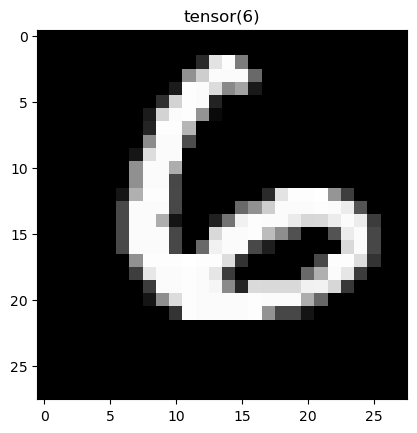

In [21]:
def plot_single_mnist_img(datasets)->None:
  data_loader = DataLoader(datasets,batch_size=32,shuffle=True)
  imgs,labels   = next(iter(data_loader))
  batch_size    = imgs.size(0)
  random_number = np.random.choice( int(batch_size) , )

  print(f"shape of batch ={imgs.shape}")
  print(f"number of imgs in each batch= {len(imgs)}")
  print(f"shape of img = {imgs[random_number].shape}")

  plt.imshow(imgs[random_number].squeeze(0),  cmap='gray');
  plt.title(label=labels[random_number])
  plt.show();

plot_single_mnist_img(mnist_data)

In [22]:
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize( mean=(mean,), std=(std,) )
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean=(mean,), std=(std,) )
])

In [23]:
train_dataset = datasets.MNIST(root='../data/',train=True,transform=train_transforms,download=False)
test_dataset  = datasets.MNIST(root='../data/',train=False,transform=test_transforms,download=False)

In [24]:
for i in range(10):
    print(np.power(i,2))

0
1
4
9
16
25
36
49
64
81


In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.conv1 = nn.Sequential(
            # Input 1 channels,  output=16 channels
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),

            # Input 16 Channels, outputs=32 channels
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),
        )
        self.trans1 = nn.Sequential(
            # Input 32 channels output=16 channels
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,bias=False,padding=1),
            nn.ReLU(),

            # Input resolution shape = (28*28*16)   output = (14*14*16)
            nn.MaxPool2d( kernel_size =2 , stride =2 , padding =0 )
        )
        
        self.conv2 =nn.Sequential(
            # input= 16 channels, output=(16 channels)
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),

            # input 16 channels and output=(32 channels)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU()
        )
        self.trans2 = nn.Sequential(
            # input 32 channels and output = 16 channels
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,bias=False),
            nn.ReLU(),

            # input = (14*14*16) output=(7*7*16)
            nn.MaxPool2d( kernel_size =2 , stride =2 , padding =0 )
        )

        self.conv3 = nn.Sequential(
            # Input=(7*7*16) and output=(7*7*16)
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),
            # Input=(7*7*16) and output=(7*7*32)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),
        )
        self.trans3 = nn.Sequential(
            #input = (7*7*32) and output=(7*7*16)
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,bias=False),
            nn.ReLU(),
            #input =(7*7*16)          output = 3*3*16 
            nn.MaxPool2d( kernel_size =2 , stride =2 , padding =0 )
        )

        self.conv4 = nn.Sequential(
            # input=(3*3*16)   output=(3*3*10)
            nn.Conv2d(in_channels=16 ,out_channels=10, kernel_size=3,stride=1,padding=1,bias=False),
            nn.AvgPool2d(kernel_size=3)
            
            
        )
        
        
    def forward(self,x):
        x = self.trans1( self.conv1(x) )
        x = self.trans2( self.conv2(x) )
        x = self.trans3( self.conv3(x) )
        x = self.conv4(x)
        x = x.view(-1,10)
        return F.log_softmax(x)

In [42]:
model = Net().to(device)

In [43]:
summary(model=model,input_data=(1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 28, 28]          --
|    └─Conv2d: 2-1                       [-1, 8, 28, 28]           72
|    └─ReLU: 2-2                         [-1, 8, 28, 28]           --
|    └─Conv2d: 2-3                       [-1, 16, 28, 28]          1,152
|    └─ReLU: 2-4                         [-1, 16, 28, 28]          --
├─Sequential: 1-2                        [-1, 16, 15, 15]          --
|    └─Conv2d: 2-5                       [-1, 16, 30, 30]          256
|    └─ReLU: 2-6                         [-1, 16, 30, 30]          --
|    └─MaxPool2d: 2-7                    [-1, 16, 15, 15]          --
├─Sequential: 1-3                        [-1, 32, 15, 15]          --
|    └─Conv2d: 2-8                       [-1, 16, 15, 15]          2,304
|    └─ReLU: 2-9                         [-1, 16, 15, 15]          --
|    └─Conv2d: 2-10                      [-1, 32, 15, 15]          4,608
|    

/tmp/ipykernel_9214/2043874046.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [47]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()

        self.conv1 = nn.Sequential(
            # Input 1 channels,  output=16 channels
            nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1,bias=False),
            nn.Dropout(p=0.1),
            nn.ReLU(),

            # Input 16 Channels, outputs=32 channels
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False),
            nn.Dropout(p=0.1),
            nn.ReLU(),
        )
        self.trans1 = nn.Sequential(
            # Input 32 channels output=16 channels
            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=1,bias=False,padding=1),
            nn.ReLU(),
            # Input resolution shape = (28*28*16)   output = (14*14*16)
            nn.MaxPool2d( kernel_size =2 , stride =2 , padding =0 )
        )
        
        self.conv2 =nn.Sequential(
            # input= 16 channels, output=(16 channels)
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False),
            nn.Dropout(p=0.1),
            nn.ReLU(),

            # input 16 channels and output=(32 channels)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
            nn.Dropout(p=0.1),
            nn.ReLU()
        )
        self.trans2 = nn.Sequential(
            # input 32 channels and output = 16 channels
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,bias=False),
            nn.ReLU(),

            # input = (14*14*16) output=(7*7*16)
            nn.MaxPool2d( kernel_size =2 , stride =2 , padding =0 )
        )

        self.conv3 = nn.Sequential(
            # Input=(7*7*16) and output=(7*7*16)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            # Input=(7*7*16) and output=(7*7*32)
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
            nn.Dropout(),
            nn.ReLU(),
        )
        self.trans3 = nn.Sequential(
            #input = (7*7*32) and output=(7*7*16)
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,bias=False),
            nn.ReLU(),
            #input =(7*7*16)          output = 3*3*16 
            nn.MaxPool2d( kernel_size =2 , stride =2 , padding =0 )
        )

        self.conv4 = nn.Sequential(
            # input=(3*3*16)   output=(3*3*10)
            nn.Conv2d(in_channels=16 ,out_channels=10, kernel_size=3,stride=1,padding=1,bias=False),
            nn.AvgPool2d(kernel_size=3)
            
            
        )
        
        
    def forward(self,x):
        x = self.trans1( self.conv1(x) )
        x = self.trans2( self.conv2(x) )
        x = self.trans3( self.conv3(x) )
        x = self.conv4(x)
        x = x.view(-1,10)
        return F.log_softmax(x)


model = Net2().to(device)
for name,weights in model.named_parameters():
    print(f"{name}\t\t {weights.shape}")

summary(model,input_data=(1,28,28));

conv1.0.weight		 torch.Size([8, 1, 3, 3])
conv1.3.weight		 torch.Size([16, 8, 3, 3])
trans1.0.weight		 torch.Size([8, 16, 1, 1])
conv2.0.weight		 torch.Size([16, 8, 3, 3])
conv2.3.weight		 torch.Size([32, 16, 3, 3])
trans2.0.weight		 torch.Size([16, 32, 1, 1])
conv3.0.weight		 torch.Size([32, 16, 3, 3])
conv3.3.weight		 torch.Size([32, 32, 3, 3])
trans3.0.weight		 torch.Size([16, 32, 1, 1])
conv4.0.weight		 torch.Size([10, 16, 3, 3])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 28, 28]          --
|    └─Conv2d: 2-1                       [-1, 8, 28, 28]           72
|    └─Dropout: 2-2                      [-1, 8, 28, 28]           --
|    └─ReLU: 2-3                         [-1, 8, 28, 28]           --
|    └─Conv2d: 2-4                       [-1, 16, 28, 28]          1,152
|    └─Dropout: 2-5                      [-1, 16, 28, 28]          --
|    └─ReLU: 2-6                         [-1, 16, 28, 28]       

/tmp/ipykernel_9214/2748164531.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
